In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
import pickle
import scipy.io as sio

import matplotlib.pyplot as plt
from tqdm import tqdm
from nn_FNO import FNO1d
from nn_step_methods import *
from ensemble_FP import ensemble_FP
import hdf5storage

2.1.1+cu121
2.1.1+cu121


In [2]:
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KS_1024.pkl', 'rb') as f: #change based on eval data location.
    test = pickle.load(f)
test=np.asarray(test[:,150000:250000])
print(test.shape)

device = 'cuda'

(1024, 100000)


In [3]:
def load_output_data_skipped(num_chunks, file_path, M, num_ens):

    output_data = np.zeros([int(M/100)+1,num_ens,1024])
    output_data_RMSE = np.zeros([int(M/100)+1,num_ens])
    output_data_FFT_X = np.zeros([int(M/100)+1,num_ens,512])

    start_ind = 0
    for k in range(num_chunks):
        out = np.load(file_path+str(k)+'.npy', allow_pickle=True)#[10000:,:,:,:]
        t_range = out.item()['prediction'].shape[0]
        output_data[start_ind:start_ind+t_range] = out.item()['prediction']
        output_data_RMSE[start_ind:start_ind+t_range] = out.item()['RMSE']
        output_data_FFT_X[start_ind:start_ind+t_range,:,:512] = out.item()['prediction'][:,:,:512]
        start_ind += t_range
        # print(start_ind)

    return torch.from_numpy(output_data).float(), torch.from_numpy(output_data_RMSE).float(), torch.from_numpy(output_data_FFT_X).float()

def load_output_data_RMSE(num_chunks, file_path, M, num_ens):

    output_data_RMSE = np.zeros([M,num_ens])

    start_ind = 0
    for k in range(num_chunks):
        out = np.load(file_path+str(k)+'.npy', allow_pickle=True)#[10000:,:,:,:]
        t_range = out.item()['RMSE'].shape[0]
        output_data_RMSE[start_ind:start_ind+t_range] = out.item()['RMSE']
        start_ind += t_range
        # print(start_ind)

    return torch.from_numpy(output_data_RMSE).float()

In [5]:
num_chunks = 100
file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/PEC4_FNO_noise_3.0_100_ens_100_wavenum_k5_long_t/PEC4_FNO_noise_3.0_100_ens_100_wavenum_k5_long_t_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/PEC4_FNO_noise_3.0_100_ens_100_wavenum_k5_long_t/PEC4_FNO_noise_3.0_100_ens_100_wavenum_k5_long_t_RMSE_chunk_"
M = 99999
N_ens = 100

In [6]:
output_data, output_data_RMSE_skipped, output_data_FFT_x = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_RMSE_full = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_meaned = output_data.mean(1)

In [7]:
num_chunks = 100
file_path_skip = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/PEC4_FNO_noise_3.0_100_ens_100_wavenum_no_FP_long_t/PEC4_FNO_noise_3.0_100_ens_100_wavenum_no_FP_long_t_skip100_chunk_"
file_path_RMSE = "/glade/derecho/scratch/cainslie/conrad_net_stability/FP_output/PEC4_FNO_noise_3.0_100_ens_100_wavenum_no_FP_long_t/PEC4_FNO_noise_3.0_100_ens_100_wavenum_no_FP_long_t_RMSE_chunk_"
M = 99999
N_ens = 100

In [8]:
output_data_no_fp, output_data_RMSE_skipped_no_fp, output_data_FFT_x_no_fp = load_output_data_skipped(num_chunks, file_path_skip, M, N_ens)
output_data_RMSE_full_no_fp = load_output_data_RMSE(num_chunks, file_path_RMSE, M, N_ens)
output_data_meaned_no_fp = output_data_no_fp.mean(1)

Text(0, 0.5, 'u(x)')

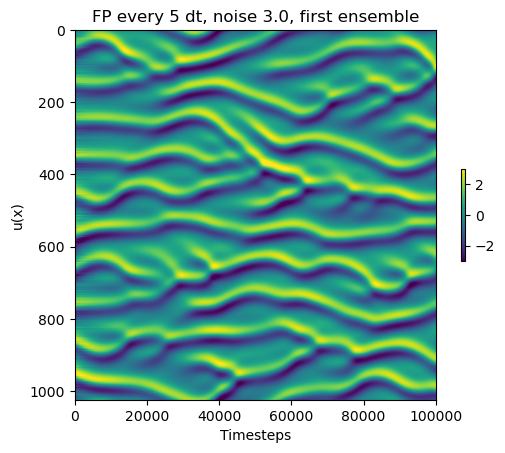

In [11]:
plt.figure(dpi=100)
plt.imshow(output_data[:,1].T,vmax=3,vmin=-3, extent=[0,100000,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('FP every 5 dt, noise 3.0, first ensemble')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')

Text(0, 0.5, 'u(x)')

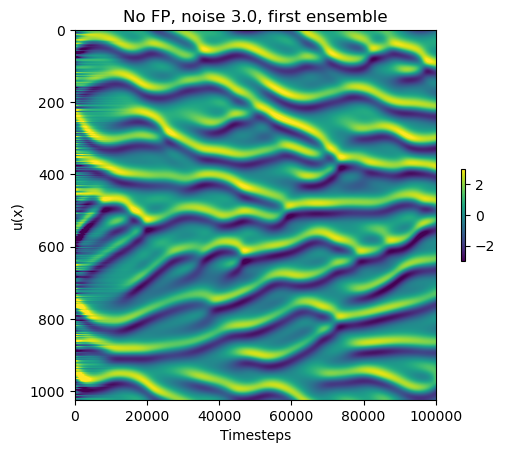

In [12]:
plt.figure(dpi=100)
plt.imshow(output_data_no_fp[:,1].T,vmax=3,vmin=-3, extent=[0,100000,1024,0], aspect=100)
plt.colorbar(shrink=.25)
plt.title('No FP, noise 3.0, first ensemble')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')

Text(0, 0.5, 'u(x)')

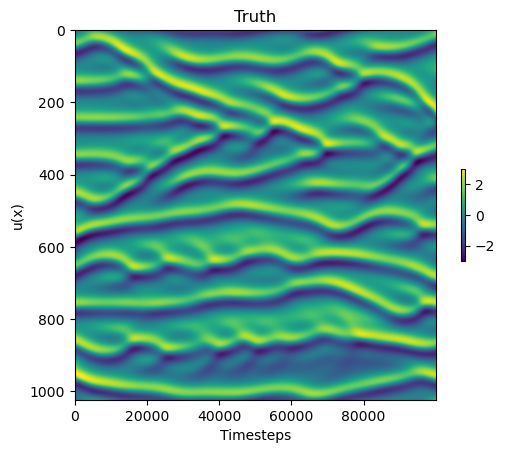

In [64]:
plt.figure(dpi=100)
plt.imshow(test[:,:100000],vmax=3,vmin=-3, aspect=100)
plt.colorbar(shrink=.25)
plt.title('Truth')
plt.xlabel('Timesteps')
plt.ylabel('u(x)')

Text(0, 0.5, 'RMSE')

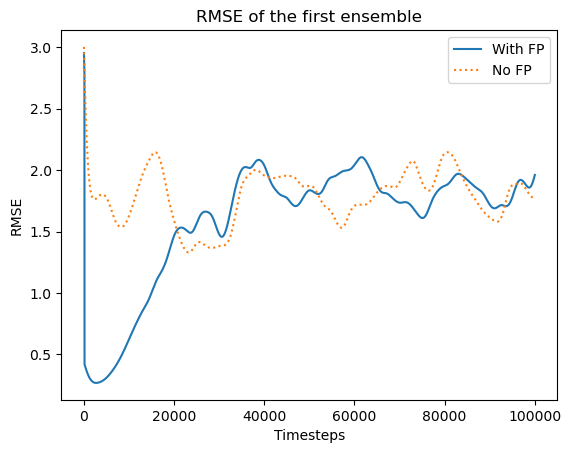

In [13]:
plt.plot(output_data_RMSE_full[:,1], label='With FP')
plt.plot(output_data_RMSE_full_no_fp[:,1],':', label='No FP')
plt.legend()
plt.title('RMSE of the first ensemble')
plt.xlabel('Timesteps')
plt.ylabel('RMSE')

In [ ]:
plt.hist(output_data[1:].flatten(),bins=100, alpha=0.75, label='With FP', density=True)
print('Done w one')
plt.hist(output_data_no_fp[1:].flatten(),bins=100, alpha=0.25, label='No FP',density=True)
print('Done w two')
plt.hist(test[:,1000:].flatten(),bins=100, alpha=0.25, label='Truth',density=True)
plt.legend()
plt.title('PDF from 1k timesteps to 100k timesteps')
plt.xscale('symlog')
plt.yscale('symlog')

Done w one


In [5]:
def u_x_xx(u):
   dx = 22/u.shape[0]
   u_x = (u[2:] - u[:-2])/(2*dx)
   u_xx = (u[2:] - 2*u[1:-1]+u[:-2])/(dx**2)
   return u_x,u_xx
u_x, u_xx = u_x_xx(test[0,:,0])
df_true = pd.DataFrame({'u_x':u_x, 'u_xx':u_xx})
for i in range(6000,7000,5): #upto 3000 rollouts
    u_1 = test[i,:,0]
    u_x, u_xx = u_x_xx(u_1)
    df_true = pd.concat([df_true,pd.DataFrame({'u_x':u_x,
            'u_xx':u_xx})], ignore_index=True)
h1 = sns.jointplot(data=df_true,x='u_x',y='u_xx',kind="kde",fill=True)
h1.ax_joint.set_xlabel("$u_{x}$")
h1.ax_joint.set_ylabel("$u_{xx}$")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.suptitle("True")
# plt.savefig('True_dist.png')

IndexError: index 6000 is out of bounds for dimension 0 with size 5000

Text(0.5, 0.98, 'True')

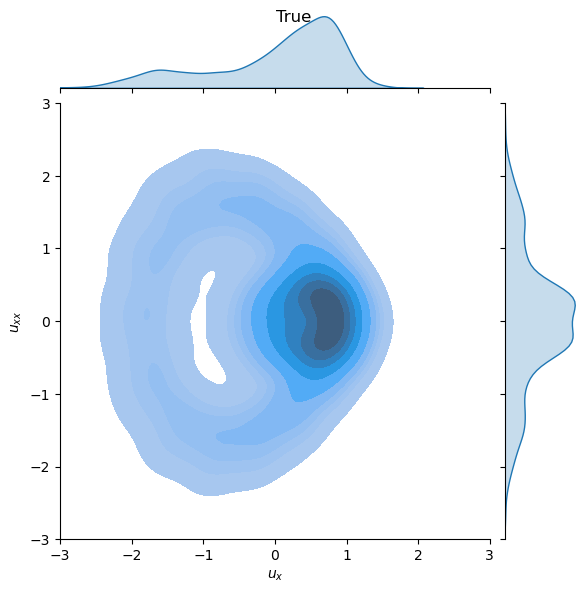

In [6]:
pred_np = pred.detach().numpy()
def u_x_xx(u):
   dx = 22/u.shape[0]
   u_x = (u[2:] - u[:-2])/(2*dx)
   u_xx = (u[2:] - 2*u[1:-1]+u[:-2])/(dx**2)
   return u_x,u_xx
u_x, u_xx = u_x_xx(pred_np[0,:,0])
df_true_1 = pd.DataFrame({'u_x':u_x,
                   'u_xx':u_xx})
for i in range(6000,7000,5): #upto 3000 rollouts
    u_1 = pred_np[i,:,0]
    u_x, u_xx = u_x_xx(u_1)
    df_true_1 = pd.concat([df_true_1,pd.DataFrame({'u_x':u_x,
            'u_xx':u_xx})], ignore_index=True)
h2 = sns.jointplot(data=df_true_1,x='u_x',y='u_xx',kind="kde",fill=True)
h2.ax_joint.set_xlabel("$u_{x}$")
h2.ax_joint.set_ylabel("$u_{xx}$")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.suptitle("True")
# plt.savefig('True_dist.png')

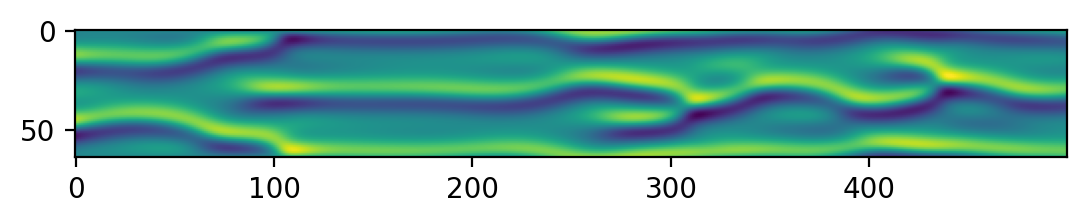

In [31]:
plt.figure(dpi=200)def fft_loss(inp,out):
        #batchsize x channels x shape
        inp_fft = torch.abs(torch.fft.fftn(inp,dim=(1))[:,:15,:])
        out_fft = torch.abs(torch.fft.fftn(out,dim=(1))[:,:15,:])
        fft_index = (inp_fft>1e-8)*(out_fft>1e-8)
        return torch.mean(torch.abs(1-(inp_fft)/(out_fft))*fft_index)

print(fft_loss(pred[1:2], test[1:2]))
plt.imshow(test.squeeze(-1)[:500,:].detach().numpy().T,vmax=3,vmin=-3)

In [54]:
output_data_FFT_x.shape

torch.Size([1000, 100, 512])

Text(0, 0.5, 'Amplitude')

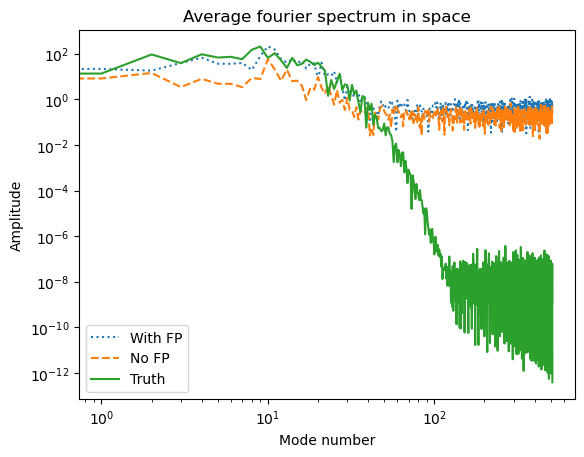

In [12]:
plt.loglog(torch.abs(torch.fft.rfft(output_data.mean(1).mean(0))),':', label='With FP')
plt.loglog(torch.abs(torch.fft.rfft(output_data_no_fp.mean(1).mean(0))),'--', label='No FP')
plt.loglog(torch.abs(torch.fft.rfft(torch.from_numpy(test.mean(1)))), label='Truth')
plt.legend()
plt.title('Average fourier spectrum in space')
plt.xlabel('Mode number')
plt.ylabel('Amplitude')

In [100]:

def fft_loss(inp,out):
        #batchsize x channels x shape
        inp_fft = torch.abs(torch.fft.fftn(inp,dim=(1))[:,:,0])
        out_fft = torch.abs(torch.fft.fftn(out,dim=(1))[:,:,0])
        fft_index = (inp_fft>1e-12)*(out_fft>1e-12)
        return torch.mean(torch.abs(1-(inp_fft)/(1e-16+out_fft))*fft_index)

fft_loss(test[0:1],test[1:2])

In [ ]:
N1=64
kfreq1 = torch.fft.fftfreq(N1) * N1
#kfreq2D = torch.meshgrid(kfreq1, kfreq2)
knrm = torch.sqrt(kfreq1**2)
knrm = knrm.flatten()
idx = np.arange(knrm.shape[0])
indices = [idx[(knrm<i+0.5)] for i in range(33)]
kbins = torch.arange(0.5, N1//2+1, 1.)
hist_bins = torch.histogram(knrm, kbins)[0]


def avg_espec(input):
    # timesteps x 1 x 64
    N = input.shape[-1]
    fourier_image = torch.fft.fftn(input, dim=(1,2))
    fourier_amplitudes = 0.5*torch.sum(torch.abs(fourier_image)**2, dim=1)

    kfreq1 = torch.fft.fftfreq(N) * N
    #kfreq2D = torch.meshgrid(kfreq1, kfreq2)
    knrm = torch.sqrt(kfreq1)#(kfreq2D[0]**2 + kfreq2D[1]**2)

    #knrm = torch.flatten(knrm,start_dim=1)#knrm.flatten()
    fourier_amplitudes = torch.flatten(fourier_amplitudes,start_dim=1)#fourier_amplitudes.flatten()

    kbins = torch.arange(0.5, N//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins = torch.tensor([torch.sum(fourier_amplitudes[:,indices[i]]) - torch.sum(fourier_amplitudes[:,indices[i-1]]) for i in range(1,33)])
    Abins = Abins * kvals**2 / hist_bins
    Abins = Abins/ torch.trapezoid(Abins, kvals)
    return Abins

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

#----- Numerical integration of ODE via fixed-step classical Runge-Kutta -----
def RK4_solve(odefunc,TimeSpan,uhat0,nt):
    h = float(TimeSpan[1]-TimeSpan[0])/nt
    print(h)
    w = uhat0
    out_vals = np.zeros([nt, w.shape[0]])
    t = TimeSpan[0]
    for i in np.arange(nt):
        w = RK4Step(odefunc, t, w, h)
        # print(np.max(w))
        t = t+h
        out_vals[i] = np.real(np.fft.ifft(vhat2uhat(t,w)))
    return out_vals

def RK4Step(odefunc, t,w,h):
    k1 = odefunc(t,w)
    k2 = odefunc(t+0.5*h, w+0.5*k1*h)
    k3 = odefunc(t+0.5*h, w+0.5*k2*h)
    k4 = odefunc(t+h,     w+k3*h)
    return w + (k1+2*k2+2*k3+k4)*(h/6.)

#----- Constructing the grid -----
L   = 2.
nx  = 512
x   = np.linspace(0.,L, nx+1)
x   = x[:nx]  

kx1 = np.linspace(0,nx/2-1, int(nx/2))
kx2 = np.linspace(1,nx/2,  int(nx/2))
kx2 = -1*kx2[::-1]
kx  = (2.* np.pi/L)*np.concatenate((kx1,kx2))

#------ Initial conditions -----
u0      = np.cos(np.pi*x)
uhat0   = np.fft.fft(u0)

#----- Parameters -----
delta  = 0.022
delta2 = delta**2
nt = 15000
t0 = 0
tf = nt*delta
print(tf)
tf = 10./np.pi
TimeSpan = [t0, tf] 

#----- Change of Variables -----
def uhat2vhat(t,uhat):
    return np.exp( -1j * (kx**3) * delta2 * t) * uhat

def vhat2uhat(t,vhat):
    return np.exp(1j * (kx**3) * delta2 * t) * vhat

#----- Define RHS -----
def uhatprime(t, uhat):
    u = np.fft.ifft(uhat)
    return 1j * (kx**2) * delta2 * uhat - 0.5j * kx * np.fft.fft(u**2)

def vhatprime(t, vhat):
    u = np.fft.ifft(vhat2uhat(t,vhat))
    return  -0.5j * kx * uhat2vhat(t, np.fft.fft(u**2) )


#----- Initial condition -----
vhat0    = uhat2vhat(t0,uhat0)

file_path ='/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/'
file_name = 'KdV_data.npz'

#------ Solving for ODE -----

out_vals = RK4_solve(vhatprime,[t0,tf],vhat0,nt)

np.savez(file_path+file_name, out_vals)

330.0
0.0002122065907891938


In [7]:
with open('/glade/derecho/scratch/cainslie/conrad_net_stability/training_data/KdV_data.npz', 'rb') as f: #change based on eval data location.
    test = np.load(f)
    test = test['arr_0']
print(test.shape)


(150000, 512)


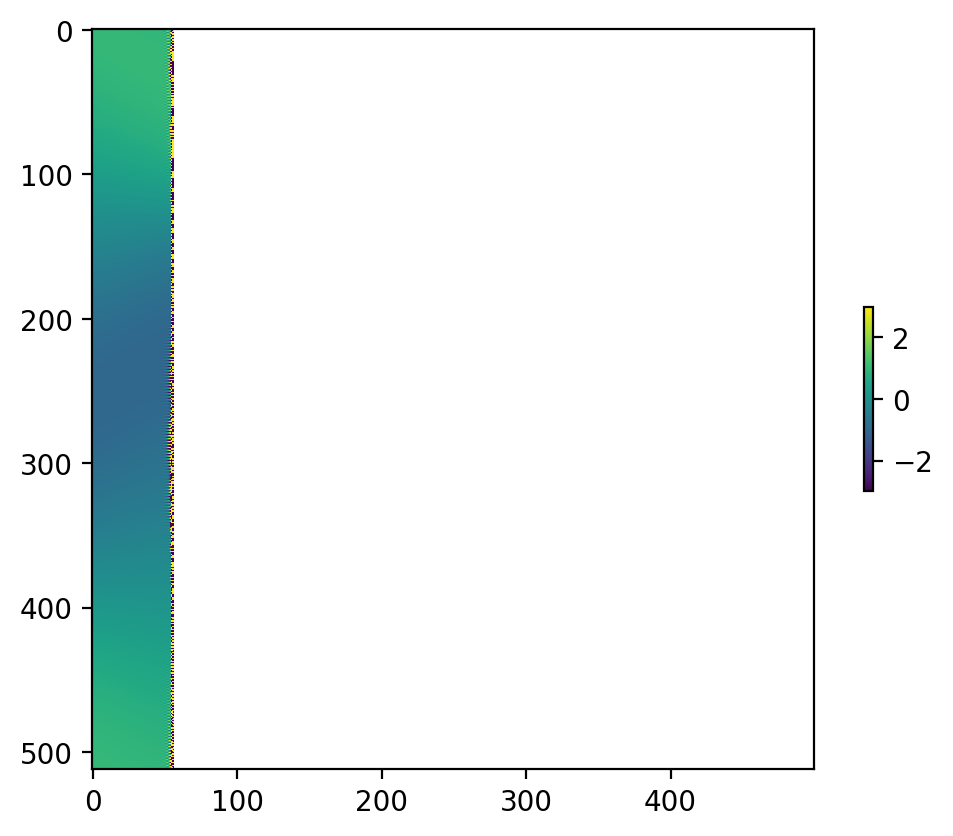

In [10]:
plt.figure(dpi=200)
plt.imshow(test[:500,:].T,vmax=3,vmin=-3)
plt.colorbar(shrink=.25)
# plt.figure(dpi=200)
# plt.imshow(test[500:1000,:].detach().numpy().T,extent=[500,1000,0,64],vmax=3,vmin=-3)
# plt.figure(dpi=200)
# plt.imshow(test[1000:1500,:].detach().numpy().T,extent=[1000,1500,0,64],vmax=3,vmin=-3)
# plt.figure(dpi=200)
# plt.imshow(test[1500:2000,:].detach().numpy().T,extent=[1500,2000,0,64],vmax=3,vmin=-3)
# plt.figure(dpi=200)
# plt.imshow(test[2000:,:].detach().numpy().T,extent=[2000,2500,0,64],vmax=3,vmin=-3)